# SDXL Naruto Style LoRA Fine-tuning
## Optimized for Google Colab T4 GPU (16GB VRAM)

This notebook fine-tunes Stable Diffusion XL to generate images in Naruto anime style using LoRA.

### Memory Optimizations Used:
- LoRA (Low-Rank Adaptation) - 99% parameter reduction
- Mixed Precision (fp16) - 50% memory reduction
- Gradient Checkpointing - Trades compute for memory
- 8-bit Adam Optimizer - Reduces optimizer state memory
- XFormers - Memory efficient attention
- Lower resolution (512x512) - Fits in VRAM budget

## Step 1: Setup Environment

In [1]:
# Install required packages
!pip install -q diffusers[torch] transformers accelerate peft datasets bitsandbytes xformers tensorboard

# Verify GPU
!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.2 MB/s eta 0:00:00
Mon Dec  1 05:25:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |     

In [4]:
# Import libraries
import os
import torch
from datetime import datetime

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
# Training Configuration
class Config:
    # Model
    pretrained_model_name = "stabilityai/stable-diffusion-xl-base-1.0"
    dataset_name = "lambdalabs/naruto-blip-captions"

    # Training - ADJUST THESE BASED ON YOUR NEEDS
    resolution = 512  # 512 for T4, we can try 768 if memory allows
    train_batch_size = 1
    gradient_accumulation_steps = 4  # Effective batch = 4
    max_train_steps = 1500  # Start with 1500, increase for better results
    learning_rate = 1e-4

    # LoRA
    lora_rank = 16  # 8-32 typical range
    lora_alpha = 32  # Usually 2x rank

    # Optimization
    mixed_precision = "fp16"
    gradient_checkpointing = True
    use_8bit_adam = True

    # Checkpoints
    output_dir = "./sdxl-naruto-lora"
    checkpointing_steps = 200
    logging_steps = 50

    # Other
    seed = 42
    num_workers = 2  # Lower for Colab
    lr_warmup_steps = 100

config = Config()

print("Configuration:")
print(f"  Resolution: {config.resolution}x{config.resolution}")
print(f"  Max training steps: {config.max_train_steps}")
print(f"  LoRA rank: {config.lora_rank}")
print(f"  Output: {config.output_dir}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
VRAM: 15.83 GB
Configuration:
  Resolution: 512x512
  Max training steps: 1500
  LoRA rank: 16
  Output: ./sdxl-naruto-lora


## Step 2: Load Dataset (Preview)

Loading Naruto dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

data/train-00000-of-00002-12944970063701(…):   0%|          | 0.00/344M [00:00<?, ?B/s]

data/train-00001-of-00002-cefa2f480689f1(…):   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

Dataset size: 1221 images


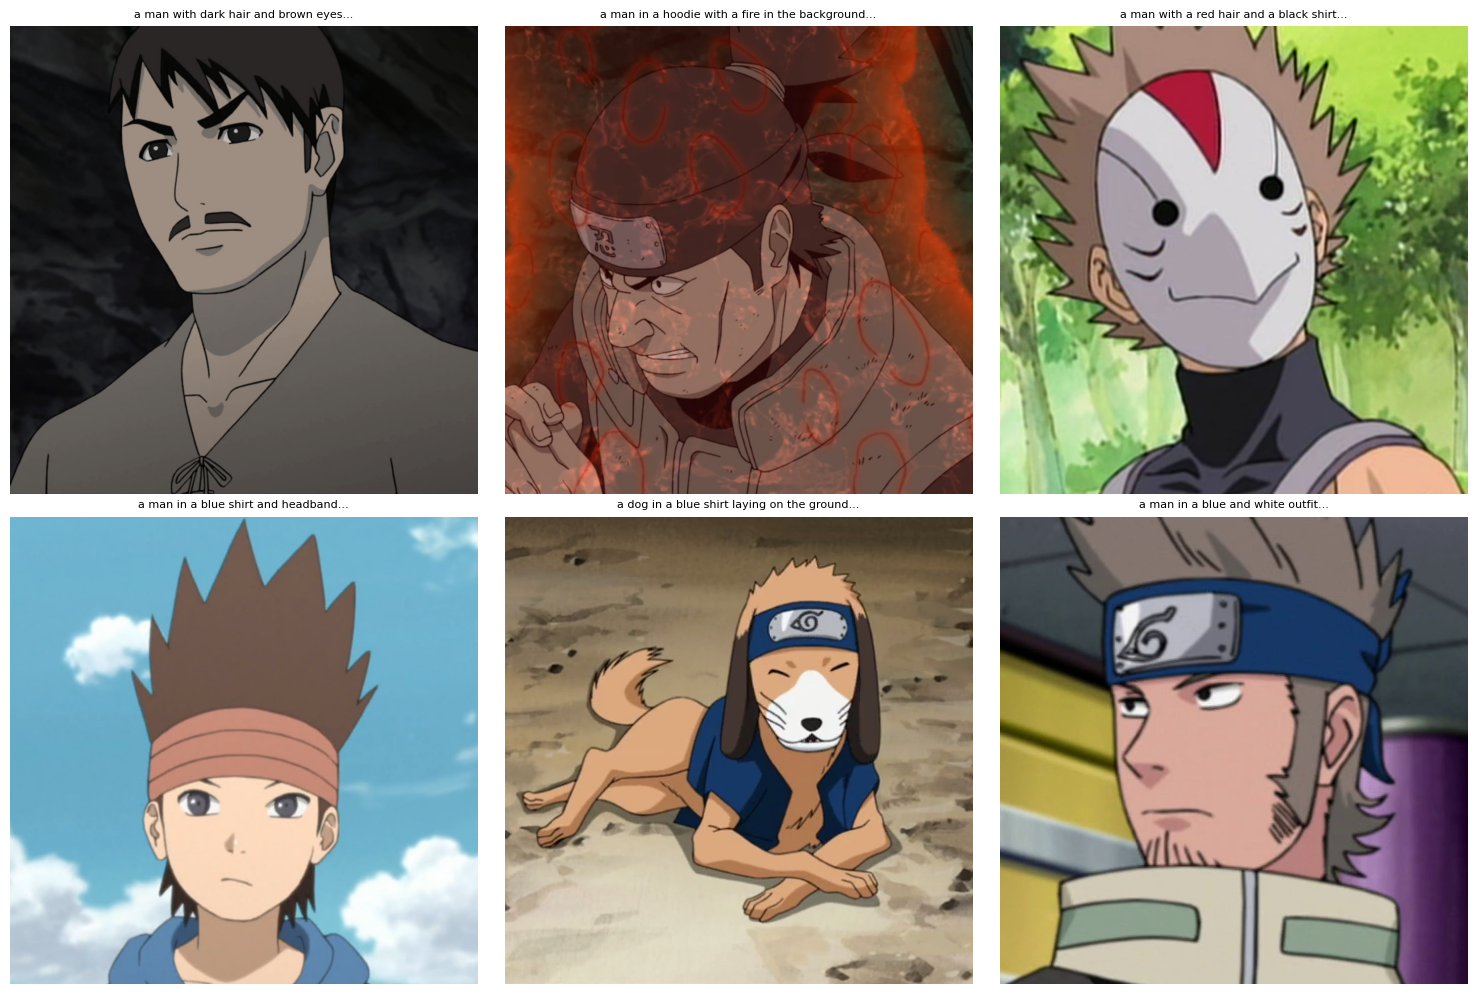


Sample captions:
1. a man with dark hair and brown eyes
2. a man in a hoodie with a fire in the background
3. a man with a red hair and a black shirt


In [5]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load dataset

print("Loading Naruto dataset...")
dataset = load_dataset(config.dataset_name, split="train")
print(f"Dataset size: {len(dataset)} images")

# Show sample images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, ax in enumerate(axes.flat):
    sample = dataset[idx]
    ax.imshow(sample["image"])
    ax.set_title(sample["text"][:50] + "...", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

print("\nSample captions:")
for i in range(3):
    print(f"{i+1}. {dataset[i]['text']}")

## Step 3: Training Script

**IMPORTANT**: This will take 2-4 hours depending on `max_train_steps`. Make sure:
- We have enough Colab GPU time remaining
- We save checkpoints regularly (already configured)
- We monitor memory usage

In [8]:
"""
TRAINING SCRIPT WITH VISIBLE LOSS
Loss prints every single step for debugging
"""

import os
import math
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from diffusers.optimization import get_scheduler
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from PIL import Image
from transformers import CLIPTokenizer, CLIPTextModel, CLIPTextModelWithProjection
import logging

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    pretrained_model_name = "stabilityai/stable-diffusion-xl-base-1.0"
    dataset_name = "lambdalabs/naruto-blip-captions"
    resolution = 512
    train_batch_size = 1
    gradient_accumulation_steps = 4
    max_train_steps = 1000
    learning_rate = 5e-5  # Reduced for stability
    lora_rank = 16
    lora_alpha = 32
    mixed_precision = "no"  # Disabled for stability
    gradient_checkpointing = True
    use_8bit_adam = True
    max_grad_norm = 0.5
    output_dir = "./sdxl-naruto-lora"
    checkpointing_steps = 200
    seed = 42
    num_workers = 2
    log_file = "training.log"

config = Config()

def setup_logger(log_path: str):
    os.makedirs(os.path.dirname(log_path) or ".", exist_ok=True)
    logger = logging.getLogger("train")
    logger.setLevel(logging.INFO)
    logger.handlers.clear()
    fmt = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    fh = logging.FileHandler(log_path, mode="w")
    fh.setFormatter(fmt)
    ch = logging.StreamHandler()
    ch.setFormatter(fmt)
    logger.addHandler(fh)
    logger.addHandler(ch)
    return logger

logger = setup_logger(os.path.join(config.output_dir, config.log_file))

logger.info("TRAINING CONFIGURATION")
logger.info(f"Learning Rate: {config.learning_rate}")
logger.info(f"Mixed Precision: {config.mixed_precision}")
logger.info(f"Max Steps: {config.max_train_steps}")
logger.info(f"Checkpoint Every: {config.checkpointing_steps} steps")

# ============================================================================
# DATASET
# ============================================================================

class NarutoDataset(Dataset):
    def __init__(self, dataset, transform, tokenizer_one, tokenizer_two):
        self.dataset = dataset
        self.transform = transform
        self.tokenizer_one = tokenizer_one
        self.tokenizer_two = tokenizer_two

    def __len__(self):
        return len(self.dataset)

    def tokenize_caption(self, caption):
        tokens_one = self.tokenizer_one(
            caption, padding="max_length",
            max_length=self.tokenizer_one.model_max_length,
            truncation=True, return_tensors="pt"
        ).input_ids[0]

        tokens_two = self.tokenizer_two(
            caption, padding="max_length",
            max_length=self.tokenizer_two.model_max_length,
            truncation=True, return_tensors="pt"
        ).input_ids[0]

        return tokens_one, tokens_two

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        image = self.transform(image)
        caption = item["text"]
        tokens_one, tokens_two = self.tokenize_caption(caption)

        return {
            "pixel_values": image,
            "input_ids_one": tokens_one,
            "input_ids_two": tokens_two,
            "caption": caption
        }

def get_transforms(resolution):
    return transforms.Compose([
        transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(resolution),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

# ============================================================================
# TRAINING
# ============================================================================

def train():
    logger.info("Initializing training...")

    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        mixed_precision=config.mixed_precision
    )

    set_seed(config.seed)
    os.makedirs(config.output_dir, exist_ok=True)

    logger.info("Loading models...")

    # Load all models
    noise_scheduler = DDPMScheduler.from_pretrained(
        config.pretrained_model_name, subfolder="scheduler"
    )
    tokenizer_one = CLIPTokenizer.from_pretrained(
        config.pretrained_model_name, subfolder="tokenizer"
    )
    tokenizer_two = CLIPTokenizer.from_pretrained(
        config.pretrained_model_name, subfolder="tokenizer_2"
    )
    text_encoder_one = CLIPTextModel.from_pretrained(
        config.pretrained_model_name, subfolder="text_encoder"
    )
    text_encoder_two = CLIPTextModelWithProjection.from_pretrained(
        config.pretrained_model_name, subfolder="text_encoder_2"
    )
    vae = AutoencoderKL.from_pretrained(
        config.pretrained_model_name, subfolder="vae"
    )
    unet = UNet2DConditionModel.from_pretrained(
        config.pretrained_model_name, subfolder="unet"
    )

    # Freeze non-trainable models
    vae.requires_grad_(False)
    text_encoder_one.requires_grad_(False)
    text_encoder_two.requires_grad_(False)
    unet.requires_grad_(False)

    if config.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    logger.info("Applying LoRA...")
    lora_config = LoraConfig(
        r=config.lora_rank,
        lora_alpha=config.lora_alpha,
        init_lora_weights="gaussian",
        target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    )
    unet = get_peft_model(unet, lora_config)

    # Print trainable parameters
    trainable = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    total = sum(p.numel() for p in unet.parameters())
    logger.info(f"Trainable params: {trainable:,} ({100*trainable/total:.2f}%)")

    if hasattr(unet, "enable_xformers_memory_efficient_attention"):
        unet.enable_xformers_memory_efficient_attention()
        logger.info("XFormers enabled")

    # Optimizer
    if config.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer = bnb.optim.AdamW8bit(unet.parameters(), lr=config.learning_rate)
        logger.info("Using 8-bit Adam")
    else:
        optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)

    logger.info("Loading dataset...")
    dataset = load_dataset(config.dataset_name, split="train")
    logger.info(f"Dataset: {len(dataset)} images")

    transform = get_transforms(config.resolution)
    train_dataset = NarutoDataset(dataset, transform, tokenizer_one, tokenizer_two)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.train_batch_size,
        shuffle=True,
        num_workers=config.num_workers
    )

    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / config.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(config.max_train_steps / num_update_steps_per_epoch)

    lr_scheduler = get_scheduler(
        "constant",
        optimizer=optimizer,
        num_warmup_steps=100 * config.gradient_accumulation_steps,
        num_training_steps=config.max_train_steps * config.gradient_accumulation_steps
    )

    # Prepare with accelerator
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    # Move models to device - USE FP32 FOR VAE
    vae.to(accelerator.device, dtype=torch.float32)
    text_encoder_one.to(accelerator.device)
    text_encoder_two.to(accelerator.device)

    logger.info("STARTING TRAINING")
    logger.info(f"Total epochs: {num_train_epochs}")
    logger.info(f"Steps per epoch (approx): {num_update_steps_per_epoch}")
    logger.info(f"Total steps: {config.max_train_steps}")

    # Training loop
    global_step = 0

    for epoch in range(num_train_epochs):
        logger.info(f"Epoch {epoch + 1}/{num_train_epochs}")

        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Encode images to latents
                with torch.no_grad():
                    pixel_values = batch["pixel_values"]
                    # Clamp to prevent extreme values
                    pixel_values = torch.clamp(pixel_values, -1.0, 1.0)

                    # Encode with FP32 VAE
                    latents = vae.encode(pixel_values).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                # Sample noise
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]

                # Sample timesteps
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (bsz,), device=latents.device
                ).long()

                # Add noise
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get text embeddings
                with torch.no_grad():
                    enc_out_1 = text_encoder_one(
                        batch["input_ids_one"],
                        output_hidden_states=True
                    )
                    enc_out_2 = text_encoder_two(
                        batch["input_ids_two"],
                        output_hidden_states=True
                    )

                    prompt_embeds = torch.cat([
                        enc_out_1.hidden_states[-2],
                        enc_out_2.hidden_states[-2]
                    ], dim=-1)

                    pooled_prompt_embeds = enc_out_2.text_embeds

                # Prepare time IDs
                add_time_ids = torch.cat([
                    torch.tensor([[
                        config.resolution, config.resolution,
                        0, 0,
                        config.resolution, config.resolution
                    ]]) for _ in range(bsz)
                ]).to(latents.device)

                # Predict noise
                model_pred = unet(
                    noisy_latents,
                    timesteps,
                    prompt_embeds,
                    added_cond_kwargs={
                        "text_embeds": pooled_prompt_embeds,
                        "time_ids": add_time_ids
                    }
                ).sample

                # Compute loss
                loss = F.mse_loss(
                    model_pred.float(),
                    noise.float(),
                    reduction="mean"
                )

                # Check for NaN/Inf
                if torch.isnan(loss) or torch.isinf(loss):
                    logger.warning(f"Invalid loss ({loss.item()}) - skipping batch")
                    continue

                # Backpropagation
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    # Clip gradients
                    grad_norm = accelerator.clip_grad_norm_(
                        unet.parameters(),
                        config.max_grad_norm
                    )

                    # Check gradient norm
                    if torch.isnan(grad_norm) or torch.isinf(grad_norm):
                        logger.warning("Invalid gradient norm - skipping update")
                        optimizer.zero_grad()
                        continue

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Update global step
            if accelerator.sync_gradients:
                global_step += 1

                current_loss = loss.item()
                logger.info(
                    f"Step {global_step:4d}/{config.max_train_steps} | Loss: {current_loss:.6f}"
                )

                # Save checkpoints
                if global_step % config.checkpointing_steps == 0:
                    if accelerator.is_main_process:
                        save_path = os.path.join(
                            config.output_dir,
                            f"checkpoint-{global_step}"
                        )
                        accelerator.unwrap_model(unet).save_pretrained(save_path)
                        logger.info(f"Checkpoint saved: {save_path}")

                # Stop at max steps
                if global_step >= config.max_train_steps:
                    break

        if global_step >= config.max_train_steps:
            break

    # Final save
    if accelerator.is_main_process:
        final_path = config.output_dir
        accelerator.unwrap_model(unet).save_pretrained(final_path)

        logger.info("TRAINING COMPLETE")
        logger.info(f"Final model saved to: {final_path}")
        logger.info(f"Total steps completed: {global_step}")
        logger.info(f"Final loss: {current_loss:.6f}")

if __name__ == "__main__":
    train()


2025-12-01 05:27:39,743 - INFO - TRAINING CONFIGURATION
INFO:train:TRAINING CONFIGURATION
2025-12-01 05:27:39,745 - INFO - Learning Rate: 5e-05
INFO:train:Learning Rate: 5e-05
2025-12-01 05:27:39,747 - INFO - Mixed Precision: no
INFO:train:Mixed Precision: no
2025-12-01 05:27:39,751 - INFO - Max Steps: 1000
INFO:train:Max Steps: 1000
2025-12-01 05:27:39,755 - INFO - Checkpoint Every: 200 steps
INFO:train:Checkpoint Every: 200 steps
2025-12-01 05:27:39,761 - INFO - Initializing training...
INFO:train:Initializing training...
2025-12-01 05:27:39,788 - INFO - Loading models...
INFO:train:Loading models...


scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

2025-12-01 05:30:18,215 - INFO - Applying LoRA...
INFO:train:Applying LoRA...
2025-12-01 05:30:19,898 - INFO - Trainable params: 23,224,320 (0.90%)
INFO:train:Trainable params: 23,224,320 (0.90%)
2025-12-01 05:30:20,483 - INFO - XFormers enabled
INFO:train:XFormers enabled
2025-12-01 05:30:20,511 - INFO - Using 8-bit Adam
INFO:train:Using 8-bit Adam
2025-12-01 05:30:20,513 - INFO - Loading dataset...
INFO:train:Loading dataset...
Repo card metadata block was not found. Setting CardData to empty.
2025-12-01 05:30:21,494 - INFO - Dataset: 1221 images
INFO:train:Dataset: 1221 images
2025-12-01 05:31:22,980 - INFO - STARTING TRAINING
INFO:train:STARTING TRAINING
2025-12-01 05:31:22,982 - INFO - Total epochs: 4
INFO:train:Total epochs: 4
2025-12-01 05:31:22,983 - INFO - Steps per epoch (approx): 306
INFO:train:Steps per epoch (approx): 306
2025-12-01 05:31:22,984 - INFO - Total steps: 1000
INFO:train:Total steps: 1000
2025-12-01 05:31:22,985 - INFO - Epoch 1/4
INFO:train:Epoch 1/4
2025-12-0

## Step 4: Monitor Training (Optional)

Check memory usage and training logs

In [9]:
# Check GPU memory
!nvidia-smi

Mon Dec  1 07:25:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             29W /   70W |   14986MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
# List checkpoints
!ls -lh {config.output_dir}

total 89M
-rw-r--r-- 1 root root 1.1K Dec  1 07:25 adapter_config.json
-rw-r--r-- 1 root root  89M Dec  1 07:25 adapter_model.safetensors
drwxr-xr-x 2 root root 4.0K Dec  1 07:25 checkpoint-1000
drwxr-xr-x 2 root root 4.0K Dec  1 05:54 checkpoint-200
drwxr-xr-x 2 root root 4.0K Dec  1 06:17 checkpoint-400
drwxr-xr-x 2 root root 4.0K Dec  1 06:40 checkpoint-600
drwxr-xr-x 2 root root 4.0K Dec  1 07:02 checkpoint-800
-rw-r--r-- 1 root root 5.1K Dec  1 07:25 README.md
-rw-r--r-- 1 root root  66K Dec  1 07:25 training.log


## Step 5: Test Inference

Generate sample images to verify the model works

Loading fine-tuned model...


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefi

✓ Model loaded!
Generating: Naruto Uzumaki eating ramen


  0%|          | 0/30 [00:00<?, ?it/s]

Generating: A boy with blue eyes in Naruto style


  0%|          | 0/30 [00:00<?, ?it/s]

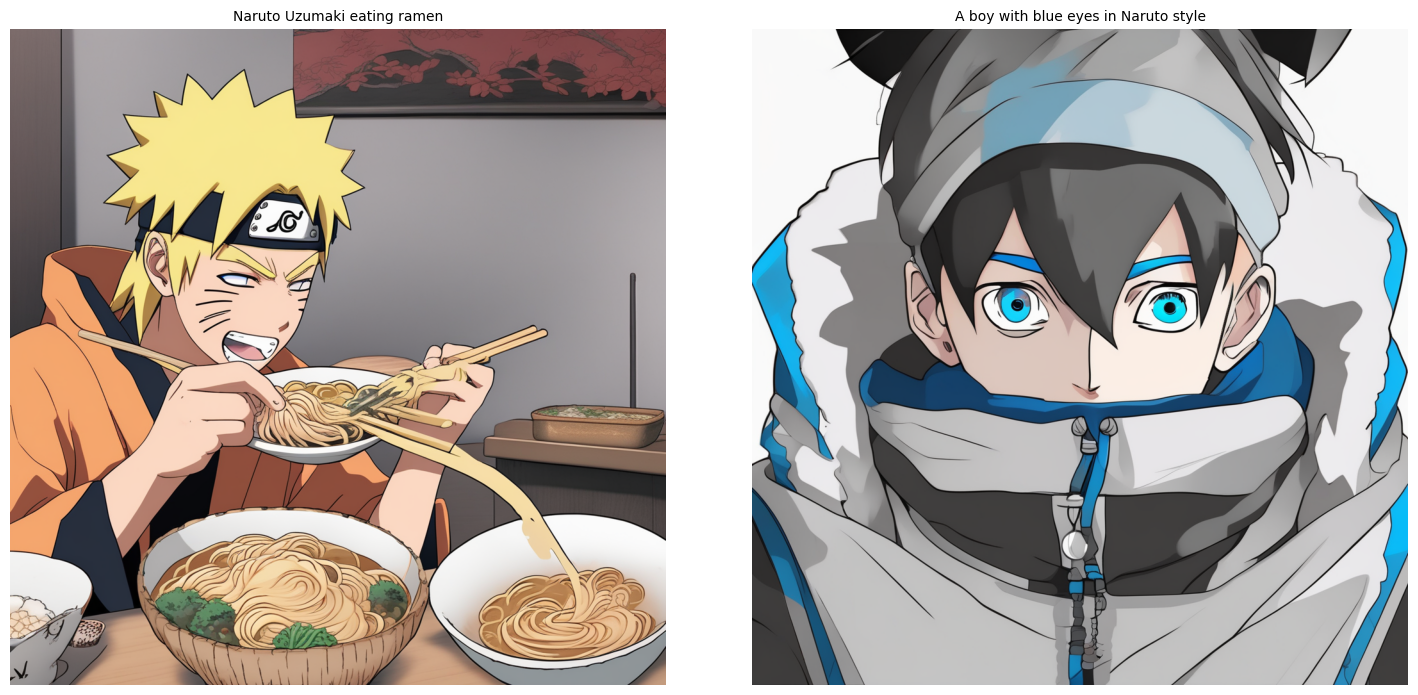


✓ Inference test complete!


In [11]:
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler
import torch
import matplotlib.pyplot as plt

# Load fine-tuned model
print("Loading fine-tuned model...")
pipeline = StableDiffusionXLPipeline.from_pretrained(
    config.pretrained_model_name,
    torch_dtype=torch.float16,
    variant="fp16"
)

# Load LoRA weights
pipeline.load_lora_weights(config.output_dir)
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()
pipeline.enable_vae_slicing()

print("✓ Model loaded!")

# Test prompts
test_prompts = [
    "Naruto Uzumaki eating ramen",
    "A boy with blue eyes in Naruto style",
    "Sasu"
]

# Generate images
fig, axes = plt.subplots(1, len(test_prompts), figsize=(15, 7))

for idx, prompt in enumerate(test_prompts):
    print(f"Generating: {prompt}")
    image = pipeline(
        prompt=prompt,
        num_inference_steps=30,
        guidance_scale=7.5
    ).images[0]

    axes[idx].imshow(image)
    axes[idx].set_title(prompt, fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Inference test complete!")

## Step 6: Download Weights

Download the trained LoRA weights to your local machine

In [13]:
# Create a zip file of the model
!zip -r sdxl-naruto-lora.zip {config.output_dir}

print("\n✓ Model weights zipped!")
print("Download 'sdxl-naruto-lora.zip' from the Files panel on the left.")

# Or use Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy to Drive
!cp -r {config.output_dir} /content/drive/MyDrive/
print("\n✓ Model also saved to Google Drive!")

updating: sdxl-naruto-lora/ (stored 0%)
updating: sdxl-naruto-lora/checkpoint-600/ (stored 0%)
updating: sdxl-naruto-lora/checkpoint-600/adapter_config.json (deflated 57%)
updating: sdxl-naruto-lora/checkpoint-600/adapter_model.safetensors (deflated 7%)
updating: sdxl-naruto-lora/checkpoint-600/README.md (deflated 66%)
updating: sdxl-naruto-lora/checkpoint-800/ (stored 0%)
updating: sdxl-naruto-lora/checkpoint-800/adapter_config.json (deflated 57%)
updating: sdxl-naruto-lora/checkpoint-800/adapter_model.safetensors (deflated 7%)
updating: sdxl-naruto-lora/checkpoint-800/README.md (deflated 66%)
updating: sdxl-naruto-lora/checkpoint-200/ (stored 0%)
updating: sdxl-naruto-lora/checkpoint-200/adapter_config.json (deflated 57%)
updating: sdxl-naruto-lora/checkpoint-200/adapter_model.safetensors (deflated 7%)
updating: sdxl-naruto-lora/checkpoint-200/README.md (deflated 66%)
updating: sdxl-naruto-lora/training.log (deflated 80%)
updating: sdxl-naruto-lora/adapter_config.json (deflated 57%)
